In [1]:
import ase.io
import znlib
import pathlib
import random

random.seed(42)

# 1. Create some data using ASE

In [2]:
atoms = ase.Atoms(
        "Si8",
        positions=[
            (0.000000000, 0.000000000, 0.000000000),
            (0.000000000, 2.715348700, 2.715348700),
            (2.715348700, 2.715348700, 0.000000000),
            (2.715348700, 0.000000000, 2.715348700),
            (4.073023100, 1.357674400, 4.073023100),
            (1.357674400, 1.357674400, 1.357674400),
            (1.357674400, 4.073023100, 4.073023100),
            (4.073023100, 4.073023100, 1.357674400),
        ],
        cell=(5.430697500, 5.430697500, 5.430697500),
        pbc=True
    )

In [3]:
for idx in range(5):
    file = pathlib.Path("configurations", f"{str(idx).zfill(3)}.extxyz")
    atoms.rattle(stdev=0.01)
    ase.io.write(file, atoms)

## Using the DVC Cache
We don't want to have the data in our repository so we use `dvc add <files>` to track them with DVC. 

In [4]:
!dvc add configurations/

⠸ Checking graph                                                   ⠋ Collecting stages from the workspace
Adding...                                                                       
!
Building data objects from configurations             |0.00 [00:00,      ?obj/s]
                                                                                
!
Building data objects from configurations             |0.00 [00:00,      ?obj/s]
                                                                                
!
  0% Checking cache in '/tikhome/fzills/PycharmProjects/CP2K_Example/.dvc/cache'
                                                                                
!
Building data objects from configurations             |0.00 [00:00,      ?obj/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00,  3.13file/s]

To track the changes with git, run:

	git add configurations.dvc

To enable auto staging, run:

	dvc config core.autostage true


# Create an Workflow

1. we use `znlib.atomistic.FileToASE` to convert the raw files into ASE Atoms objects
2. we use `znlib.atomistic.CP2KNode` to compute energies, forces and stress of each `ase.Atoms` object.
    - On the first run we need to guess the Wavefunction
    - On all subsequent runs we use the Wavefunction from the first run as a restart point. If we change the first run, this will affect all other runs! Consider using the first run only as a restart point for performance if you might want to change it later.

In [5]:
data_nodes = []
cp2k_nodes = []

for idx, file in enumerate(pathlib.Path("configurations/").glob("*.extxyz")):
    data = znlib.atomistic.FileToASE(file=file, name=f"atoms_{idx}")
    data_nodes.append(data)
    cp2k = znlib.atomistic.CP2KNode(
            atoms=data @ "atoms",
            input_file="cp2k.yaml",
            dependencies=["BASIS_SET", "GTH_POTENTIALS"],
            wfn_restart=cp2k_nodes[0].wfn_restart_file if len(cp2k_nodes) > 0 else None,
            name=f"cp2k_{idx}",
            cp2k_shell="mpirun cp2k_shell.psmp"
        )
    cp2k_nodes.append(cp2k)

The File you are adding as a dependency does not seem to be tracked by DVC. Please run 'dvc add configurations/000.extxyz' to avoid tracking the file directly with GIT.
The File you are adding as a dependency does not seem to be tracked by DVC. Please run 'dvc add configurations/002.extxyz' to avoid tracking the file directly with GIT.
The File you are adding as a dependency does not seem to be tracked by DVC. Please run 'dvc add configurations/001.extxyz' to avoid tracking the file directly with GIT.
The File you are adding as a dependency does not seem to be tracked by DVC. Please run 'dvc add configurations/004.extxyz' to avoid tracking the file directly with GIT.
The File you are adding as a dependency does not seem to be tracked by DVC. Please run 'dvc add configurations/003.extxyz' to avoid tracking the file directly with GIT.
The File you are adding as a dependency does not seem to be tracked by DVC. Please run 'dvc add configurations/005.extxyz' to avoid tracking the file direc

We write the graph for all the Nodes we created so far.

In [6]:
[x.write_graph() for x in data_nodes]
[x.write_graph() for x in cp2k_nodes]

2022-11-10 09:20:36,769 (WARNING): Running DVC command: 'dvc stage add -n atoms_0 ...'
2022-11-10 09:20:39,950 (WARNING): Running DVC command: 'dvc stage add -n atoms_1 ...'
2022-11-10 09:20:43,010 (WARNING): Running DVC command: 'dvc stage add -n atoms_2 ...'
2022-11-10 09:20:46,036 (WARNING): Running DVC command: 'dvc stage add -n atoms_3 ...'
2022-11-10 09:20:49,334 (WARNING): Running DVC command: 'dvc stage add -n atoms_4 ...'
2022-11-10 09:20:52,604 (WARNING): Running DVC command: 'dvc stage add -n atoms_5 ...'
2022-11-10 09:20:55,888 (WARNING): Running DVC command: 'dvc stage add -n cp2k_0 ...'
2022-11-10 09:20:59,115 (WARNING): Running DVC command: 'dvc stage add -n cp2k_1 ...'
2022-11-10 09:21:02,538 (WARNING): Running DVC command: 'dvc stage add -n cp2k_2 ...'
2022-11-10 09:21:06,810 (WARNING): Running DVC command: 'dvc stage add -n cp2k_3 ...'
2022-11-10 09:21:10,009 (WARNING): Running DVC command: 'dvc stage add -n cp2k_4 ...'
2022-11-10 09:21:13,298 (WARNING): Running DVC c

[None, None, None, None, None, None]

In [7]:
!dvc repro

'configurations.dvc' didn't change, skipping                                    
Stage 'atoms_5' didn't change, skipping
Stage 'atoms_0' didn't change, skipping
Running stage 'cp2k_0':
> python3 -c "from znlib.atomistic.cp2k import CP2KNode; CP2KNode.load(name='cp2k_0').run_and_save()" 
Writing atoms to nodes/cp2k_0/outputs.db: 100%|███| 1/1 [00:00<00:00, 11.40it/s]
  0% Transferring|                                   |0/4 [00:00<?,     ?file/s]
!
  0%|          |cp2k.inp                           0.00/? [00:00<?,        ?B/s]
                                                                                
  0%|          |cp2k.out                           0.00/? [00:00<?,        ?B/s]
                                                                                
!
  0%|          |cp2k-RESTART.wfn                   0.00/? [00:00<?,        ?B/s]
                                                                                
!
  0%|          |memory://.nZBBWzBGbdhJqt3Hyrx5wC.tm0.00/? 

We can use `dvc dag --mermaid` to visualize the graph in the mermaid format and visualize it e.g. with https://mermaid.live/

[![](https://mermaid.ink/img/pako:eNp1k7FuwyAURX8lenNSGdupEw-dsnZKppaqejI4QbHBwrhVFeXfS1JDVaBM5pw33HeFL9AoxqGGtlOfzQm1WRx2VC7mI60krxTQqH58zyi8_XW5dyRyhXd55ErvisitvSsj92hdo2QrjpNGI5QcH9hHE41Vt7EhPycSb5yKA2-divOSzLk4LyHOxXnJavV0DxTUNuNN0NiMt0FZMyZZUJTjJCjJ8TTO07hI4zKN10Hh6YWq9ELVPwt5TmAJPdc9Cmaf5uU2RcGceM8p1PaT8RanzlCg8mpHcTJq_yUbqI2e-BKmgaHhO4FHjT3ULXajpQPKF6V-75wJo_Tzz_O__wXXb1mO37E?type=png)](https://mermaid.live/edit#pako:eNp1k7FuwyAURX8lenNSGdupEw-dsnZKppaqejI4QbHBwrhVFeXfS1JDVaBM5pw33HeFL9AoxqGGtlOfzQm1WRx2VC7mI60krxTQqH58zyi8_XW5dyRyhXd55ErvisitvSsj92hdo2QrjpNGI5QcH9hHE41Vt7EhPycSb5yKA2-divOSzLk4LyHOxXnJavV0DxTUNuNN0NiMt0FZMyZZUJTjJCjJ8TTO07hI4zKN10Hh6YWq9ELVPwt5TmAJPdc9Cmaf5uU2RcGceM8p1PaT8RanzlCg8mpHcTJq_yUbqI2e-BKmgaHhO4FHjT3ULXajpQPKF6V-75wJo_Tzz_O__wXXb1mO37E)

# Add to the Workflow

Let us add another configuration using ASE

In [8]:
file = pathlib.Path("configurations", f"005.extxyz")
atoms.rattle(stdev=0.01)
ase.io.write(file, atoms)

In [9]:
# Add the new file to DVC as well
!dvc add configurations/

⠼ Checking graph                                                   ⠋ Checking graph
Adding...                                                                       
!
Building data objects from configurations             |0.00 [00:00,      ?obj/s]
                                                                                
!
Building data objects from configurations             |0.00 [00:00,      ?obj/s]
                                                                                
!
  0% Checking cache in '/tikhome/fzills/PycharmProjects/CP2K_Example/.dvc/cache'
                                                                                
!
Building data objects from configurations             |0.00 [00:00,      ?obj/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00,  3.37file/s]

To track the changes with git, run:

	git add configurations.dvc

To enable auto staging, run:

	dvc config core.autostage true


We will now add the File to our Graph and use CP2K once more to compute the energy.

In [10]:
data = znlib.atomistic.FileToASE(file=file, name="atoms_5")
cp2k = znlib.atomistic.CP2KNode(
            atoms=data @ "atoms",
            input_file="cp2k.yaml",
            dependencies=["BASIS_SET", "GTH_POTENTIALS"],
            wfn_restart=cp2k_nodes[0].wfn_restart_file,
            name="cp2k_5",
        )
data.write_graph()
cp2k.write_graph()

The File you are adding as a dependency does not seem to be tracked by DVC. Please run 'dvc add configurations/005.extxyz' to avoid tracking the file directly with GIT.


2022-11-10 09:28:56,204 (WARNING): Running DVC command: 'dvc stage add -n atoms_5 ...'
2022-11-10 09:28:59,529 (WARNING): Running DVC command: 'dvc stage add -n cp2k_5 ...'


Now can run the graph and look at the results.

In [11]:
!dvc repro

'configurations.dvc' didn't change, skipping                                    
Stage 'atoms_4' didn't change, skipping
Stage 'atoms_3' didn't change, skipping
Stage 'atoms_0' didn't change, skipping
Stage 'cp2k_0' is cached - skipping run, checking out outputs                   
                                                                                
Stage 'cp2k_3' didn't change, skipping                                          
Stage 'atoms_1' didn't change, skipping
Stage 'cp2k_1' is cached - skipping run, checking out outputs                   
                                                                                
Stage 'atoms_5' didn't change, skipping
Stage 'cp2k_5' didn't change, skipping                                          
Stage 'atoms_2' didn't change, skipping
Stage 'cp2k_4' didn't change, skipping                                          
Stage 'cp2k_2' didn't change, skipping                                          
Use `dvc push` to send your upd

In [12]:
cp2k = znlib.atomistic.CP2KNode["cp2k_5"]

In [13]:
cp2k.outputs[0].get_potential_energy()

-851.3087221855

# Analysis

Assuming that the initial coordinates where close to an equilibrium. We would expect with `Atoms.rattle` to increase the energy.
If we plot the energy we can verify our assumption. 

In [14]:
energies = [x.load(x.node_name).outputs[0].get_potential_energy() for x in cp2k_nodes]

In [15]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Deviation from equilibrium / a.u.')

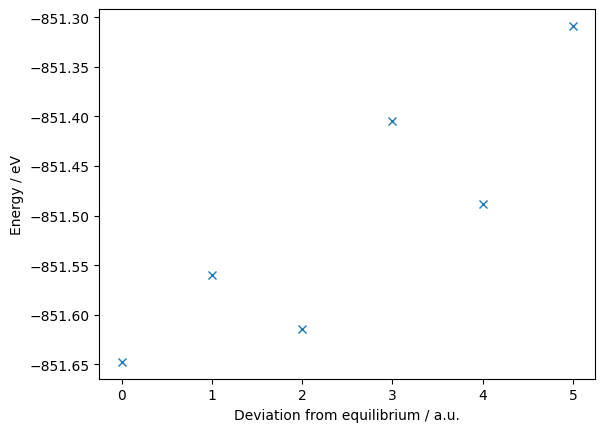

In [16]:
fig, ax = plt.subplots()
ax.plot(energies, "x")
ax.set_ylabel("Energy / eV")
ax.set_xlabel("Deviation from equilibrium / a.u.")

In [17]:
!git add .

In [18]:
!git commit -m "Initial Run"

[master (root-commit) 814afcf] Initial Run
 25 files changed, 9035 insertions(+)
 create mode 100644 .dvc/.gitignore
 create mode 100644 .dvc/config
 create mode 100644 .dvcignore
 create mode 100644 .gitignore
 create mode 100644 BASIS_SET
 create mode 100644 GTH_POTENTIALS
 create mode 100644 configurations.dvc
 create mode 100644 cp2k.yaml
 create mode 100644 dvc.lock
 create mode 100644 dvc.yaml
 create mode 100644 main.ipynb
 create mode 100644 nodes/atoms_0/.gitignore
 create mode 100644 nodes/atoms_1/.gitignore
 create mode 100644 nodes/atoms_2/.gitignore
 create mode 100644 nodes/atoms_3/.gitignore
 create mode 100644 nodes/atoms_4/.gitignore
 create mode 100644 nodes/atoms_5/.gitignore
 create mode 100644 nodes/cp2k_0/.gitignore
 create mode 100644 nodes/cp2k_1/.gitignore
 create mode 100644 nodes/cp2k_2/.gitignore
 create mode 100644 nodes/cp2k_3/.gitignore
 create mode 100644 nodes/cp2k_4/.gitignore
 create mode 100644 nodes/cp2k_5/.gitignore
 create mode 100644 params.yaml


In [20]:
!dvc push

  0% Transferring|                                  |0/43 [00:00<?,     ?file/s]
!
  0%|          |/tikhome/fzills/PycharmProjects/CP20.00/? [00:00<?,        ?B/s]
  0%|          |/tikhome/fzills/PycharmProjects/C0.00/541 [00:00<?,        ?B/s]

!

  0%|          |/tikhome/fzills/PycharmProjects/CP20.00/? [00:00<?,        ?B/s]

  0%|          |/tikhome/fzills/PycharmProjects/C0.00/541 [00:00<?,        ?B/s]


!


  0%|          |/tikhome/fzills/PycharmProjects/CP20.00/? [00:00<?,        ?B/s]


  0%|          |/tikhome/fzills/PycharmProjects/C0.00/541 [00:00<?,        ?B/s]



!



  0%|          |/tikhome/fzills/PycharmProjects/CP20.00/? [00:00<?,        ?B/s]



  0%|          |/tikhome/fzills/PycharmProjects/C0.00/541 [00:00<?,        ?B/s]




!




  0%|          |/tikhome/fzills/PycharmProjects/CP20.00/? [00:00<?,        ?B/s]




  0%|          |/tikhome/fzills/PycharmProjects/C0.00/541 [00:00<?,        ?B/s]





!





  0%|          |/tikhome/fzills/PycharmProjects/CP20.00/?